In [1]:
import sys, os
import gzip
from collections import Counter
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt

### Loading .fastq.gz files R2 (cell barcode) and R3 (UMI)

In [2]:
try: 
    inputBCfq = 'merged_R2_E6.5.fastq.gz'
    inputUMIfq = 'merged_R3_E6.5.fastq.gz'
except:
    sys.exit("Please, provide:\n(1) Input fastq file (R2) where all 14 bps are the cell barcode; \n(2) the fastq file (R3) with the UMI; \n(3) optional to provide number of cell bacodes to select")

In [3]:
try:
    th = int(sys.argv[3])
except:
    th = 0

In [4]:
if not os.path.isfile(inputBCfq) or not os.path.isfile(inputUMIfq):
    sys.exit("Input files not found")

## Read barcodes from fastq file R2 and R3
### Count number of lines in file and divided by 4 (beacuse of format). Check if UMIs and CBC are the same, if not .update

In [5]:
cbc_count = Counter() #dict to count indexes
cbc_umi = {}
with gzip.open(inputBCfq) as fBC, gzip.open(inputUMIfq) as fUMI:
    for idx, (lBC, lUMI) in enumerate(zip(fBC,fUMI)):
        lstrBC, lstrUMI = [str(line.rstrip().rsplit()[0], 'utf-8') for line in [lBC,lUMI]]
        lnum = np.mod(idx, 4)
        if lnum == 1:
            umi = lstrUMI
            cbc = lstrBC
            cbc_count.update([cbc])
            try:
                cbc_umi[cbc].update([umi])
            except:
                cbc_umi[cbc] = Counter([umi])
print('fastq file read')

fastq file read


### Create comfortable barcode data frame

In [6]:
cbc_count_df = pd.Series(cbc_count).sort_values(ascending=False)
cbc_umi_df = pd.Series(cbc_umi)
cbc_umi_df = cbc_umi_df.loc[cbc_count_df.index]
cbc_umiN_df = cbc_umi_df.apply(lambda x: len(x))

In [7]:
cbc_count_df

CGTGATGACTTATC    4190
CTACTATGCTTAGG    4058
CTGGCACTCTTGGA    3968
GAAGTAGACTGACA    3918
TCACATACTTCACT    3880
                  ... 
CCCTTACTGCGAGA       1
GATAGAGACGAATG       1
CGCATAGCAACGTC       1
TTAAGGTTGGTCAT       1
ATTNTTCTAACGAN       1
Length: 86426, dtype: int64

In [8]:
cbc_umiN_df #why differnece in number of counts (reads vs umis)

CGTGATGACTTATC    3990
CTACTATGCTTAGG    3861
CTGGCACTCTTGGA    3790
GAAGTAGACTGACA    3732
TCACATACTTCACT    3685
                  ... 
CCCTTACTGCGAGA       1
GATAGAGACGAATG       1
CGCATAGCAACGTC       1
TTAAGGTTGGTCAT       1
ATTNTTCTAACGAN       1
Length: 86426, dtype: int64

In [9]:
cbc_df = pd.DataFrame({'reads': cbc_count_df, 'umis': cbc_umiN_df})
for nt in ['N','A','C','T','G']:
    cbc_df[nt+'_in_bc'] = cbc_df.apply(lambda x: x.name.count(nt), axis = 1)
cbc_df['index'] = range(len(cbc_df))
del cbc_count_df
del cbc_count
del cbc_umi

In [10]:
cbc_df

,reads,umis,N_in_bc,A_in_bc,C_in_bc,T_in_bc,G_in_bc,index
CGTGATGACTTATC,4190,3990,0,3,3,5,3,0
CTACTATGCTTAGG,4058,3861,0,3,3,5,3,1
CTGGCACTCTTGGA,3968,3790,0,2,4,4,4,2
GAAGTAGACTGACA,3918,3732,0,6,2,2,4,3
TCACATACTTCACT,3880,3685,0,4,5,5,0,4
...,...,...,...,...,...,...,...,...
CCCTTACTGCGAGA,1,1,0,3,5,3,3,86421
GATAGAGACGAATG,1,1,0,6,1,2,5,86422
CGCATAGCAACGTC,1,1,0,4,5,2,3,86423
TTAAGGTTGGTCAT,1,1,0,3,1,6,4,86424


In [11]:
fcbc_df = cbc_df.loc[[idx for idx in cbc_df.index if 'G'*7 not in idx]] # 'G'*7 condition?

In [12]:
len(fcbc_df)

86351

output total table

## Saving table

In [13]:
cbc_df.to_csv(inputBCfq[:inputBCfq.rindex('_R')] + '_cellBC.tsv', sep = '\t')
print('output table written')

output table written


### Function to find neighbor barcodes given a hamming distance (the number of bit different bit counts)

In [14]:
def find_compatible_barcodes(barcode, HDmax = 0):
    """Given a barcode sequence and a maximum Hamming distance, it returns a list of compatible barcode sequences"""
    nt = ['N'] if HDmax == 0 else ['N','C','T','G','A']
    HDmax = 1 if HDmax == 0 else HDmax
    compatible_barcodes = set([barcode])
    for hd in range(1, HDmax+1):
        comb = [''.join(l) for l in it.product(nt, repeat = hd)]
        for c in comb:
            for p in it.permutations(range(len(barcode)), hd):
                s0 = barcode
                for x, l in zip(p, c):
                    s0 = s0[:x] + l + s0[x+1:]
                compatible_barcodes.add(s0)
    return list(compatible_barcodes)

### Find threshold and characteristic barcodes

In [15]:
first_N = fcbc_df[fcbc_df['N_in_bc']>0].head(1)
first_lowUMI = fcbc_df[(fcbc_df['umis']<0.8*(4**len(umi)))&(fcbc_df['G_in_bc']<16)].head(1)

In [16]:
idxs = []
for i in range(20):
    bc1 = fcbc_df.index[i]
    bc1_comps = find_compatible_barcodes(bc1, HDmax = 2)
    f_bc1_comps = [x for x in bc1_comps if x in fcbc_df.index]
    idx = fcbc_df.loc[f_bc1_comps].sort_values(by = 'index').index[1]
    idxs.append(idx)
sub_cbc_df = fcbc_df.loc[idxs]
min_idx = sub_cbc_df[sub_cbc_df['umis']<0.8*(4**6)]['index'].min()-1
while min_idx not in fcbc_df['index'].values:
    min_idx += 1
last_bc = fcbc_df[fcbc_df['index']==min_idx].index[0]
print('threshold determined')

threshold determined


### Make QC plots

In [17]:
def template_plot(ncols = 1, nrows = 1, figsize = (3*1.6,3)):
    """starts a plt.subplots plot, with my own default properties (grid, spines...)"""
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize = figsize)
    if ncols == 1 and nrows == 1:
        axs.spines['top'].set_visible(False)
        axs.spines['right'].set_visible(False)
        axs.grid(axis = 'y', c = 'silver', ls = '--')
    elif ncols == 1 and nrows != 1 or ncols != 1 and nrows == 1:
        for ax in axs:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(axis = 'y', c = 'silver', ls = '--')
    else:
        for i in range(axs.shape[0]):
            for ax in axs[i]:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.grid(axis = 'y', c = 'silver', ls = '--')
    return fig, axs

In [18]:
cbc_df = fcbc_df

In [19]:
fig, axs = template_plot(ncols = 3, nrows = 1, figsize=(3*3*1.6, 3))
ax = axs[0]
im = ax.scatter(range(len(cbc_df)), cbc_df['reads'], c = cbc_df['umis']/1e3, s = 1, rasterized = True)
ax.axvline(x = first_N['index'][0], ls = '--', c = 'r')
ax.text(first_N['index'][0], 100, str(first_N['index'][0]))
if first_lowUMI['index'].values[0] > 0:
    ax.axvline(x = first_lowUMI['index'][0], ls = '--', c = 'k')
    ax.text(first_lowUMI['index'][0], 10, str(first_lowUMI['index'][0]))
ax.axvline(x = min_idx, ls = '--', c = 'silver')
ax.text(min_idx, 1000, str(min_idx))
if th > 0:
    ax.axvline(x = th, ls = '--', c = 'cyan')
    ax.text(th, 500, str(th))
ax.set_xlabel('sorted barcodes'); ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(0.75,len(cbc_df)*1.1)
cbc = fig.colorbar(im, ax = ax, label = 'x1e3 UMIs', shrink = 0.8)
ax.set_ylabel('total reads')
ax = axs[1]
hist = ax.hist(np.log10(cbc_df['reads']), bins = 1000)
ax.axvline(np.log10(first_N['reads'][0]), c = 'r', ls = '--')
ax.text(np.log10(1.05*first_N['reads'][0]), 1e3, 'first N')
if first_lowUMI['index'].values[0] > 0:
    ax.axvline(np.log10(first_lowUMI['reads'][0]), c = 'k', ls = '--')
    ax.text(np.log10(1.05*first_lowUMI['reads'][0]), 1e3, 'low 0.8UMI')
ax.axvline(np.log10(cbc_df.loc[last_bc, 'reads']), c = 'silver', ls = '--')
ax.text(np.log10(1.05*cbc_df.loc[last_bc, 'reads']), 1e4, 'threshold')
ax.set_yscale('log'); ax.set_xlabel('log10(reads)'); ax.set_ylabel('frequency')
if th > 0 :
    ax.axvline(np.log10(th), c = 'cyan', ls = '--')
    ax.text(np.log10(1.05*th), 1e2, 'manual')
ax = axs[2]
bcn = cbc_df.sort_values(by='N_in_bc').index
ax.scatter(cbc_df.loc[bcn,'reads'], cbc_df.loc[bcn,'umis'], c = cbc_df.loc[bcn,'N_in_bc'], s = 1, rasterized = True)
ax.set_xlabel('reads'); ax.set_ylabel('umis'); ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(0.75,len(cbc_df)*1.1)
fig.savefig(inputBCfq[:inputBCfq.rindex('_R')] + '_cellBC_countInfo.pdf', bbox_inches = 'tight')
plt.close()

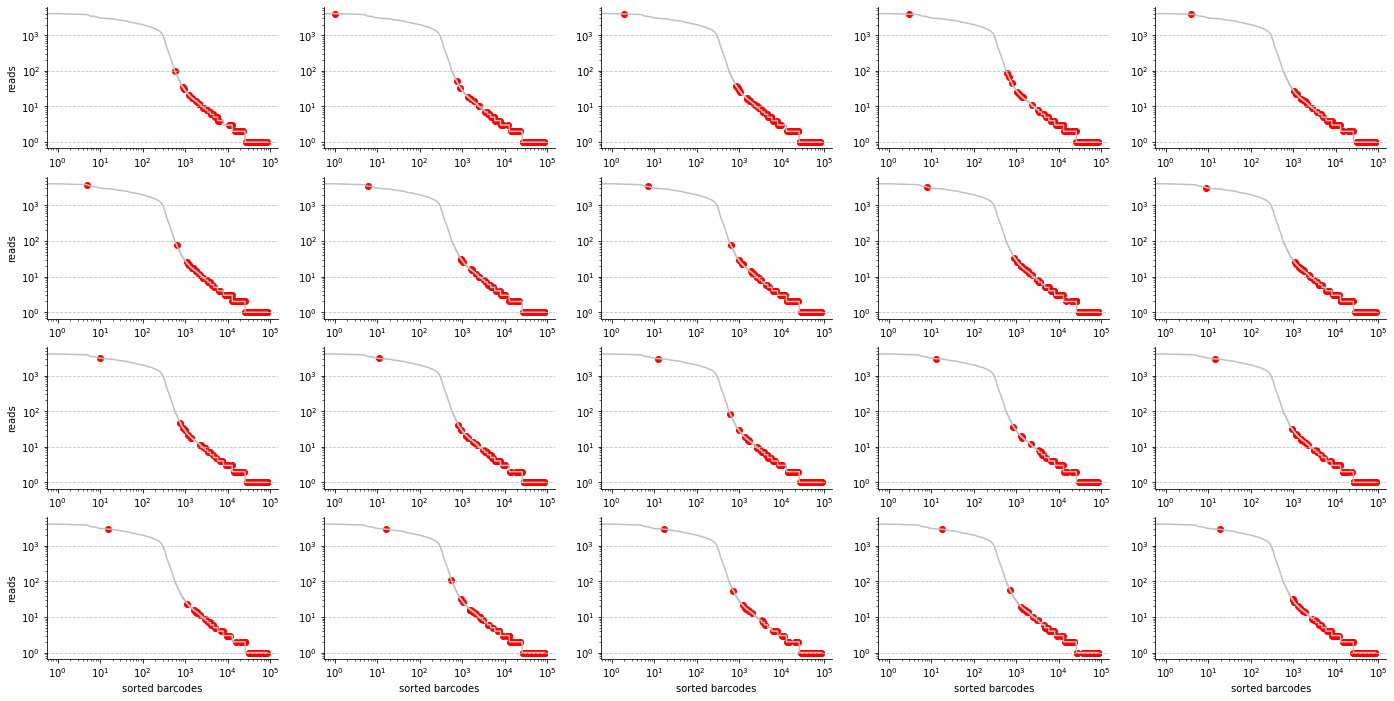

In [20]:
fig, axs = template_plot(ncols = 5, nrows = 4, figsize=(5*3*1.6, 4*3))
myaxs = axs.reshape(20)
for i in range(20):
    bc1 = fcbc_df.index[i]
    bc1_comps = find_compatible_barcodes(bc1, HDmax = 2)
    f_bc1_comps = [x for x in bc1_comps if x in cbc_df.index]
    myaxs[i].plot(range(len(cbc_df)), cbc_df['reads'], c = 'silver')
    myaxs[i].scatter(cbc_df.loc[f_bc1_comps, 'index'], cbc_df.loc[f_bc1_comps, 'reads'], c = 'r')
    myaxs[i].set_xscale('log'); myaxs[i].set_yscale('log')
    ax.set_xlim(0.5,1.2*len(cbc_df))
for ax in axs[-1]:
    ax.set_xlabel('sorted barcodes')
for i in range(len(axs)):
    axs[i][0].set_ylabel('reads')
fig.savefig(inputBCfq[:inputBCfq.rindex('_R')] + '_cellBC_HD2.pdf', bbox_inches = 'tight')

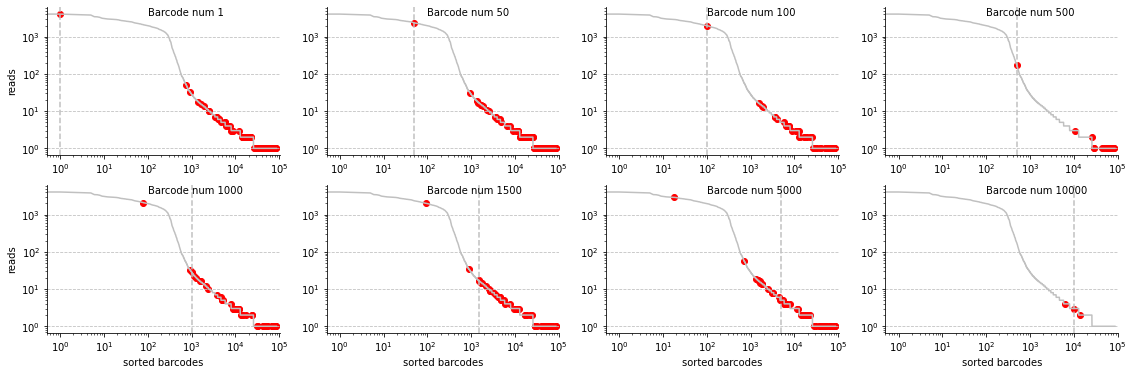

In [21]:
fig, axs = template_plot(ncols = 4, nrows = 2, figsize=(4*3*1.6, 2*3))
myaxs = axs.reshape(8)
for ax, i in zip(myaxs,[1, 50,100,500,1000,1500,5000, 10000]):
    bc1 = fcbc_df.index[i]
    bc1_comps = find_compatible_barcodes(bc1, HDmax = 2)
    f_bc1_comps = [x for x in bc1_comps if x in cbc_df.index]
    ax.plot(range(len(cbc_df)), cbc_df['reads'], c = 'silver')
    ax.scatter(cbc_df.loc[f_bc1_comps, 'index'], cbc_df.loc[f_bc1_comps, 'reads'], c = 'r')
    ax.axvline(i, ls = '--', c = 'silver')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.text(100, 0.9*cbc_df['reads'].max(), 'Barcode num ' + str(i), ha = 'left')
    ax.set_xlim(0.5,1.2*len(cbc_df))
for ax in axs[-1]:
    ax.set_xlabel('sorted barcodes')
for i in range(len(axs)):
    axs[i][0].set_ylabel('reads')
fig.savefig(inputBCfq[:inputBCfq.rindex('_R')] + '_cellBC_examples_HD2.pdf', bbox_inches = 'tight')

In [22]:
print('plots made')

plots made


print table of selected barcodes

In [23]:
if th > 0:
    min_idx = th
pd.DataFrame(pd.Series({idx: idx for idx in fcbc_df[fcbc_df['index']<=min_idx].index})).to_csv(inputBCfq[:inputBCfq.rindex('_R')] + '_barcodeList.tsv', sep = '\t', header = None)

In [24]:
print('barcode list prited')
sys.exit()

barcode list prited


SystemExit: 

/home/paupascual/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
